In [1]:
import sagemaker
import boto3
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import roc_curve, auc, f1_score
import random
import numpy as np

2023-01-16 18:15:43.069040: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-16 18:15:59.694594: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Dataset
It is explored in detail in **RSNA_dataset_EDA.ipynb** and how I prepared it in **RSNA_dataset_prep.ipynb**

In [2]:
!unzip train_images_processed.zip

Archive:  train_images_processed.zip
   creating: train_images_processed/
   creating: train_images_processed/10589/
  inflating: train_images_processed/10589/1967460233.png  
  inflating: train_images_processed/10589/195400299.png  
  inflating: train_images_processed/10589/2059883725.png  
  inflating: train_images_processed/10589/605115808.png  
  inflating: train_images_processed/10589/363277205.png  
   creating: train_images_processed/1025/
  inflating: train_images_processed/1025/1122776493.png  
  inflating: train_images_processed/1025/773597682.png  
  inflating: train_images_processed/1025/1803952236.png  
  inflating: train_images_processed/1025/347069540.png  
   creating: train_images_processed/10130/
  inflating: train_images_processed/10130/1013166704.png  
  inflating: train_images_processed/10130/1672636630.png  
  inflating: train_images_processed/10130/1360338805.png  
  inflating: train_images_processed/10130/388811999.png  
  inflating: train_images_processed/10130

In [3]:
# upload the datset to S3 bucket

s3_path = sagemaker.Session().upload_data(bucket='breast-cancer-project', 
                                                  path='./train_images_processed', 
                                                  key_prefix='train_images_processed')

# Estimator training job

In [2]:
from sagemaker import get_execution_role
from sagemaker.tensorflow import TensorFlow

In [3]:
hyperparameters={'epochs': 30, 'batch_size':16, 'lr':0.001}

In [4]:
role = get_execution_role()

estimator = TensorFlow(
    role=role,
    base_job_name="siamese-tf2-keras",
    instance_count=1,
    instance_type="ml.p2.xlarge",
    entry_point="train_model.py",
    framework_version="2.3",
    py_version="py37",
    hyperparameters=hyperparameters
)

In [7]:
s3_path = 's3://breast-cancer-project'
estimator.fit({'data': s3_path}, wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: siamese-tf2-keras-2023-01-16-13-15-42-858


2023-01-16 13:15:43 Starting - Starting the training job...
2023-01-16 13:16:10 Starting - Preparing the instances for training.........
2023-01-16 13:17:32 Downloading - Downloading input data......
2023-01-16 13:18:32 Training - Downloading the training image...
2023-01-16 13:19:13 Training - Training image download completed. Training in progress.........2023-01-16 13:20:15.953942: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2023-01-16 13:20:15.954172: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
2023-01-16 13:20:15.961107: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.2
2023-01-16 13:20:15.997441: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2023-01-16 13:20:17,5

# Deployment to an end point

In [8]:
predictor = estimator.deploy(initial_instance_count=1, instance_type="ml.p2.xlarge") 

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker.tensorflow.model:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating model with name: siamese-tf2-keras-2023-01-16-13-33-02-639
INFO:sagemaker:Creating endpoint-config with name siamese-tf2-keras-2023-01-16-13-33-02-639
INFO:sagemaker:Creating endpoint with name siamese-tf2-keras-2023-01-16-13-33-02-639


--------!

# Evaluation

In [2]:
# prepare test set and do some inference
train_df = pd.read_csv("new_train.csv")
train_df.drop("Unnamed: 0", axis=1, inplace=True)
train_df['path'] =train_df['patient_id'].astype(str) +'/'+train_df['image_id'].astype(str)+'.png'
train_df['lat_view'] = train_df['laterality']+"_"+train_df['view']
train_df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path,lat_view
0,1,10130,388811999,L,MLO,71.0,1,1,1,0.0,0,B,49,False,10130/388811999.png,L_MLO
1,1,10130,613462606,L,CC,71.0,1,1,1,0.0,0,B,49,False,10130/613462606.png,L_CC
2,1,10130,1360338805,L,CC,71.0,1,1,1,0.0,0,B,49,False,10130/1360338805.png,L_CC
3,1,10130,1672636630,L,MLO,71.0,1,1,1,0.0,0,B,49,False,10130/1672636630.png,L_MLO
4,1,10130,1013166704,R,CC,71.0,0,0,0,NaN,0,B,49,False,10130/1013166704.png,R_CC


In [3]:
imgs_paths = []
pairs_paths = []
labels = []
base_dir = 'train_images_processed'
for patient_id in os.listdir(base_dir):
    case_df = train_df[train_df['patient_id']==int(patient_id)]
    case_labels = case_df['cancer'].values
    if 1 in case_labels:
        label=1
    else:
        label=0
    L_MLO =  case_df[case_df['lat_view'] == 'L_MLO']['path'].values[0]
    L_CC =  case_df[case_df['lat_view'] == 'L_CC']['path'].values[0]
    R_MLO =  case_df[case_df['lat_view'] == 'R_MLO']['path'].values[0]
    R_CC = case_df[case_df['lat_view'] == 'R_CC']['path'].values[0]
    imgs_paths.append(os.path.join(base_dir, L_MLO))
    imgs_paths.append(os.path.join(base_dir, L_CC))
    labels.append(label)
    pairs_paths.append(os.path.join(base_dir, R_MLO))
    pairs_paths.append(os.path.join(base_dir, R_CC))
    labels.append(label)
print(len(imgs_paths), len(pairs_paths), len(labels))
data = list((zip(imgs_paths,pairs_paths, labels )))
random.Random(4).shuffle(data)
img_paths, pair_paths, labels = zip(*data)

800 800 800


In [4]:
val_split = 0.2
test_split=0.25

In [5]:
val_index = int(val_split*len(imgs_paths))
val_imgs =list(img_paths[:val_index])
val_pairs = list(pair_paths[:val_index])
val_labels = list(labels[:val_index])
train_imgs = list(img_paths[val_index:])
train_pairs = list(pair_paths[val_index:])
train_labels = list(labels[val_index:])
test_index = int(test_split*len(train_imgs))
test_imgs = train_imgs[:test_index]
test_pairs = train_pairs[:test_index]
test_labels = train_labels[:test_index]
train_imgs = train_imgs[test_index:]
train_pairs = train_pairs[test_index:]
train_labels = train_labels[test_index:]

In [6]:
# build the testing dataset and data input pipeline
def build_test_dataset(imgsPaths, pairsPaths, labels):
    print("[INFO] creating a tf.data input pipeline..")
    testDS = tf.data.Dataset.from_tensor_slices(imgsPaths)
    testDSPair = tf.data.Dataset.from_tensor_slices((pairsPaths, labels))


    testDS = tf.data.Dataset.zip((testDS, testDSPair))
    testDS = (testDS
        .map(preprocess_pairs, num_parallel_calls=tf.data.experimental.AUTOTUNE)   
        .cache()
        .batch(16)
        .prefetch(tf.data.experimental.AUTOTUNE)
    )
    return testDS

In [7]:
def parse_function(filename):
    image_string = tf.io.read_file(filename)

    #Don't use tf.image.decode_image, or the output shape will be undefined
    image = tf.image.decode_png(image_string, channels=1)

    #This will convert to float values in [0, 1]
    image = tf.image.convert_image_dtype(image, tf.float32)

    image = tf.image.resize(image, [512, 512])
    return image

In [8]:
def preprocess_pairs(image, pair):
    return (
        (parse_function(image),
         parse_function(pair[0])),
        pair[1]
    )

In [43]:
!unzip model.zip

Archive:  model.zip
   creating: model/
   creating: model/00000001/
   creating: model/00000001/variables/
  inflating: model/00000001/variables/variables.data-00000-of-00001  
  inflating: model/00000001/variables/variables.index  
  inflating: model/00000001/saved_model.pb  
   creating: model/00000001/assets/


In [9]:
model = tf.keras.models.load_model('./model/00000001')

2023-01-16 18:17:17.277909: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-01-16 18:17:17.278004: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-16-64-32.ec2.internal): /proc/driver/nvidia/version does not exist
2023-01-16 18:17:17.281773: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
test_DS = build_test_dataset(test_imgs, test_pairs, test_labels)

[INFO] creating a tf.data input pipeline..


In [11]:
model.evaluate(test_DS)

2023-01-16 18:17:30.375041: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 402653184 exceeds 10% of free system memory.
2023-01-16 18:17:30.599013: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 402653184 exceeds 10% of free system memory.
2023-01-16 18:17:33.517533: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 100663296 exceeds 10% of free system memory.
2023-01-16 18:17:33.719226: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 100663296 exceeds 10% of free system memory.
2023-01-16 18:17:33.916878: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 268435456 exceeds 10% of free system memory.


10/10 [==============================] - 74s 7s/step - loss: 0.6560 - accuracy: 0.5625 - auc: 0.6371


[0.6559737324714661, 0.5625, 0.6371396780014038]

In [22]:
# test set accuracy
def test_model(y_pred, y_true):
    correct = 0
    for pred, y_true_ in zip(y_pred, y_true):
        y_pred_ = (pred[0] > 0.5).astype(int)
        #print(y_true, pred[0], y_pred)
        if (np.array_equal(y_true_, y_pred_)):
            correct = correct+ 1
    acc = (correct/len(y_true)) * 100
    return acc

In [13]:
def plot_AUC(y_pred, y_true):
    plt.figure()
    fpr_test, tpr_test, thresholds_test = roc_curve(y_true, y_pred)
    auc_test = auc(fpr_test, tpr_test)
    plt.plot(fpr_test, tpr_test, color='green', marker='.', label='Siamese (auc = %0.3f)' % auc_test)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
    return auc_test

In [14]:
def f1_score_calc(y_pred, y_true):
    y_pred = np.array([(pred[0] > 0.5).astype(int) for pred in y_pred])  
    f1 = f1_score(y_true, y_pred)
    return f1

In [18]:
y_pred = model.predict(test_DS)

10/10 [==============================] - 64s 6s/step


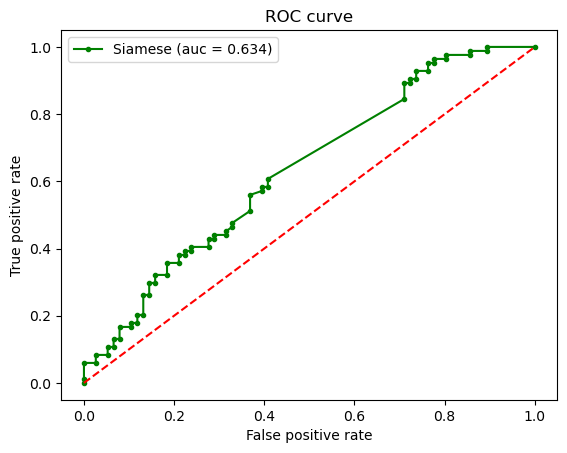

In [23]:
y_true = np.concatenate([y for x, y in test_DS], axis=0) 
acc = test_model(y_pred, y_true)
auc_test = plot_AUC(y_pred, y_true)
f1 = f1_score_calc(y_pred, y_true)

In [24]:
print("Siamese model evaluation Metrics: Accuracy={}, AUC={:.2f}, F1 score={:.2f}".format(acc, auc_test, f1))

Siamese model evaluation Metrics: Accuracy=56.25, AUC=0.63, F1 score=0.52
